In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
import ast
df=pd.read_csv("C:/Users/USER/Desktop/cars_data.csv")
df.shape[0]
df

,Price,Model,Year,لون السيارة,نوع الوقود,أصل السيارة,رخصة السيارة,نوع الجير,الزجاج,قوة الماتور,عداد السيارة,عدد الركاب,وسيلة الدفع,معروضة,أصحاب سابقون,إضافات
0,['100000'],كيا اوبتيما,2014.0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000.0,75000,4+1,نقدا فقط,للبيع فقط,يد اولى,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nفتحة...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,['60000'],كيا سورينتو,2007.0,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500.0,130000,7+1,إمكانية التقسيط,للبيع أو التبديل,2,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nفتحة...
4,['43500'],هونداي افانتي,2006.0,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600.0,NaN,NaN,نقدا فقط,للبيع فقط,NaN,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nجنطا...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7772,['48000'],فورد ترانزيت,2002.0,أبيض,ديزل,عمومي,فلسطينية,عادي,الكتروني,2400.0,00000,7+1,نقدا فقط,للبيع فقط,5,NaN
7773,['87000'],بيجو بارتنر,2018.0,فضي,ديزل,خصوصي,فلسطينية,عادي,الكتروني,1600.0,50000,4+1,نقدا فقط,للبيع فقط,يد صفر,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nوساد...
7774,['126000'],كيا سورينتو,2017.0,بترولي,ديزل,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2200.0,100,6+1,نقدا فقط,للبيع فقط,ثانيه,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nفتحة...
7775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have 7777 rows of data that contain a lot of columns that are totally useless because all of its columns are NaN so we need to drop them

Drop All the rows that all of its data are NaN , After that we have reached to 6864 data rows instead of 7777 

In [237]:
df=df.dropna(how='all')
df.shape[0]



6864

In [238]:
df.isna().any()
percentage_of_missing_data=df.isna().sum()/df.shape[0]
percentage_of_missing_data


Price           0.000000
Model           0.000000
Year            0.000000
لون السيارة     0.000000
نوع الوقود      0.000000
أصل السيارة     0.000000
رخصة السيارة    0.000000
نوع الجير       0.000000
الزجاج          0.000000
قوة الماتور     0.000000
عداد السيارة    0.282780
عدد الركاب      0.113199
وسيلة الدفع     0.000000
معروضة          0.000000
أصحاب سابقون    0.240385
إضافات          0.072990
dtype: float64

Printing the Percentage of the missing data 


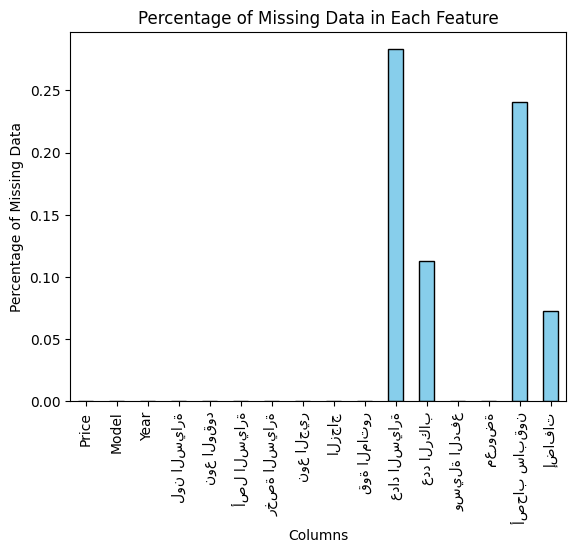

In [239]:
percentage_of_missing_data=df.isna().sum()/df.shape[0]
percentage_of_missing_data.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Data')
plt.title('Percentage of Missing Data in Each Feature')

plt.show()

In [240]:
import re

def convert_to_numeric(data):
    numbers = re.findall(r'\d+', str(data))   
    return sum(map(int, numbers)) if numbers else np.nan

df['عدد الركاب'] = df['عدد الركاب'].apply(convert_to_numeric)
df

C:\Users\USER\AppData\Local\Temp\ipykernel_18748\215409113.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['عدد الركاب'] = df['عدد الركاب'].apply(convert_to_numeric)


,Price,Model,Year,لون السيارة,نوع الوقود,أصل السيارة,رخصة السيارة,نوع الجير,الزجاج,قوة الماتور,عداد السيارة,عدد الركاب,وسيلة الدفع,معروضة,أصحاب سابقون,إضافات
0,['100000'],كيا اوبتيما,2014.0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000.0,75000,5.0,نقدا فقط,للبيع فقط,يد اولى,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nفتحة...
3,['60000'],كيا سورينتو,2007.0,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500.0,130000,8.0,إمكانية التقسيط,للبيع أو التبديل,2,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nفتحة...
4,['43500'],هونداي افانتي,2006.0,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600.0,NaN,NaN,نقدا فقط,للبيع فقط,NaN,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nجنطا...
6,['5500'],فيات 127,1982.0,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,906.0,شغال,5.0,إمكانية التقسيط,للبيع فقط,00,مُكيّف\nمسجل CD
7,['54000'],بيجو 208,2014.0,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1200.0,38000,5.0,نقدا فقط,للبيع فقط,NaN,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nجنطات مغنيسيو...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771,['45000'],كيا مورننغ,2015.0,فيراني,كهرباء,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1000.0,130000,5.0,إمكانية التقسيط,للبيع فقط,2,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nجنطات مغنيسيو...
7772,['48000'],فورد ترانزيت,2002.0,أبيض,ديزل,عمومي,فلسطينية,عادي,الكتروني,2400.0,00000,8.0,نقدا فقط,للبيع فقط,5,NaN
7773,['87000'],بيجو بارتنر,2018.0,فضي,ديزل,خصوصي,فلسطينية,عادي,الكتروني,1600.0,50000,5.0,نقدا فقط,للبيع فقط,يد صفر,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nوساد...
7774,['126000'],كيا سورينتو,2017.0,بترولي,ديزل,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2200.0,100,7.0,نقدا فقط,للبيع فقط,ثانيه,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nفتحة...


In [241]:
df["عدد الركاب"].isna().sum()


777

In [242]:
column_to_process = df[['عدد الركاب']]
model=KNNImputer(n_neighbors=1000)
new_data = model.fit_transform(column_to_process)
df['عدد الركاب'] = new_data
df['عدد الركاب'] = np.floor(df['عدد الركاب']).astype(int)

df


C:\Users\USER\AppData\Local\Temp\ipykernel_18748\446992061.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['عدد الركاب'] = new_data
C:\Users\USER\AppData\Local\Temp\ipykernel_18748\446992061.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['عدد الركاب'] = np.floor(df['عدد الركاب']).astype(int)


,Price,Model,Year,لون السيارة,نوع الوقود,أصل السيارة,رخصة السيارة,نوع الجير,الزجاج,قوة الماتور,عداد السيارة,عدد الركاب,وسيلة الدفع,معروضة,أصحاب سابقون,إضافات
0,['100000'],كيا اوبتيما,2014.0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000.0,75000,5,نقدا فقط,للبيع فقط,يد اولى,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nفتحة...
3,['60000'],كيا سورينتو,2007.0,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500.0,130000,8,إمكانية التقسيط,للبيع أو التبديل,2,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nفتحة...
4,['43500'],هونداي افانتي,2006.0,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600.0,NaN,5,نقدا فقط,للبيع فقط,NaN,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nجنطا...
6,['5500'],فيات 127,1982.0,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,906.0,شغال,5,إمكانية التقسيط,للبيع فقط,00,مُكيّف\nمسجل CD
7,['54000'],بيجو 208,2014.0,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1200.0,38000,5,نقدا فقط,للبيع فقط,NaN,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nجنطات مغنيسيو...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771,['45000'],كيا مورننغ,2015.0,فيراني,كهرباء,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1000.0,130000,5,إمكانية التقسيط,للبيع فقط,2,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nجنطات مغنيسيو...
7772,['48000'],فورد ترانزيت,2002.0,أبيض,ديزل,عمومي,فلسطينية,عادي,الكتروني,2400.0,00000,8,نقدا فقط,للبيع فقط,5,NaN
7773,['87000'],بيجو بارتنر,2018.0,فضي,ديزل,خصوصي,فلسطينية,عادي,الكتروني,1600.0,50000,5,نقدا فقط,للبيع فقط,يد صفر,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nوساد...
7774,['126000'],كيا سورينتو,2017.0,بترولي,ديزل,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2200.0,100,7,نقدا فقط,للبيع فقط,ثانيه,مُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\nفتحة...


In [243]:
car_size=df.groupby('عدد الركاب').size().reset_index(name="count")
car_size

,عدد الركاب,count
0,0,1
1,1,10
2,2,49
3,3,110
4,4,76
5,5,5689
6,6,94
7,7,624
8,8,179
9,9,18


In [244]:
df["إضافات"]=df["إضافات"].fillna("")
df["فتحة سقف"]=df["إضافات"].apply(lambda x: 1 if "فتحة سقف" in x else 0)
df=df.drop(columns=["إضافات"])
df

C:\Users\USER\AppData\Local\Temp\ipykernel_18748\3204524848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["إضافات"]=df["إضافات"].fillna("")
C:\Users\USER\AppData\Local\Temp\ipykernel_18748\3204524848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["فتحة سقف"]=df["إضافات"].apply(lambda x: 1 if "فتحة سقف" in x else 0)


,Price,Model,Year,لون السيارة,نوع الوقود,أصل السيارة,رخصة السيارة,نوع الجير,الزجاج,قوة الماتور,عداد السيارة,عدد الركاب,وسيلة الدفع,معروضة,أصحاب سابقون,فتحة سقف
0,['100000'],كيا اوبتيما,2014.0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000.0,75000,5,نقدا فقط,للبيع فقط,يد اولى,1
3,['60000'],كيا سورينتو,2007.0,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500.0,130000,8,إمكانية التقسيط,للبيع أو التبديل,2,1
4,['43500'],هونداي افانتي,2006.0,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600.0,NaN,5,نقدا فقط,للبيع فقط,NaN,0
6,['5500'],فيات 127,1982.0,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,906.0,شغال,5,إمكانية التقسيط,للبيع فقط,00,0
7,['54000'],بيجو 208,2014.0,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1200.0,38000,5,نقدا فقط,للبيع فقط,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771,['45000'],كيا مورننغ,2015.0,فيراني,كهرباء,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1000.0,130000,5,إمكانية التقسيط,للبيع فقط,2,0
7772,['48000'],فورد ترانزيت,2002.0,أبيض,ديزل,عمومي,فلسطينية,عادي,الكتروني,2400.0,00000,8,نقدا فقط,للبيع فقط,5,0
7773,['87000'],بيجو بارتنر,2018.0,فضي,ديزل,خصوصي,فلسطينية,عادي,الكتروني,1600.0,50000,5,نقدا فقط,للبيع فقط,يد صفر,0
7774,['126000'],كيا سورينتو,2017.0,بترولي,ديزل,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2200.0,100,7,نقدا فقط,للبيع فقط,ثانيه,1


Dropping the "معروضة" column

In [245]:
df=df.drop(columns=["معروضة", "وسيلة الدفع"])
df

,Price,Model,Year,لون السيارة,نوع الوقود,أصل السيارة,رخصة السيارة,نوع الجير,الزجاج,قوة الماتور,عداد السيارة,عدد الركاب,أصحاب سابقون,فتحة سقف
0,['100000'],كيا اوبتيما,2014.0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000.0,75000,5,يد اولى,1
3,['60000'],كيا سورينتو,2007.0,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500.0,130000,8,2,1
4,['43500'],هونداي افانتي,2006.0,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600.0,NaN,5,NaN,0
6,['5500'],فيات 127,1982.0,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,906.0,شغال,5,00,0
7,['54000'],بيجو 208,2014.0,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1200.0,38000,5,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771,['45000'],كيا مورننغ,2015.0,فيراني,كهرباء,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1000.0,130000,5,2,0
7772,['48000'],فورد ترانزيت,2002.0,أبيض,ديزل,عمومي,فلسطينية,عادي,الكتروني,2400.0,00000,8,5,0
7773,['87000'],بيجو بارتنر,2018.0,فضي,ديزل,خصوصي,فلسطينية,عادي,الكتروني,1600.0,50000,5,يد صفر,0
7774,['126000'],كيا سورينتو,2017.0,بترولي,ديزل,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2200.0,100,7,ثانيه,1


Turning the data type of the price into number


In [246]:
df["Price"] = df["Price"].apply(lambda x: ast.literal_eval(x)[0] if pd.notna(x) else x)
df["Price"] = pd.to_numeric(df["Price"], errors='coerce')
df


,Price,Model,Year,لون السيارة,نوع الوقود,أصل السيارة,رخصة السيارة,نوع الجير,الزجاج,قوة الماتور,عداد السيارة,عدد الركاب,أصحاب سابقون,فتحة سقف
0,100000,كيا اوبتيما,2014.0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000.0,75000,5,يد اولى,1
3,60000,كيا سورينتو,2007.0,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500.0,130000,8,2,1
4,43500,هونداي افانتي,2006.0,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600.0,NaN,5,NaN,0
6,5500,فيات 127,1982.0,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,906.0,شغال,5,00,0
7,54000,بيجو 208,2014.0,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1200.0,38000,5,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771,45000,كيا مورننغ,2015.0,فيراني,كهرباء,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1000.0,130000,5,2,0
7772,48000,فورد ترانزيت,2002.0,أبيض,ديزل,عمومي,فلسطينية,عادي,الكتروني,2400.0,00000,8,5,0
7773,87000,بيجو بارتنر,2018.0,فضي,ديزل,خصوصي,فلسطينية,عادي,الكتروني,1600.0,50000,5,يد صفر,0
7774,126000,كيا سورينتو,2017.0,بترولي,ديزل,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2200.0,100,7,ثانيه,1


Replacing The بي ام دبليو car brand with BMW to avoid duplication in the car models and then splitting the feature "Model" into two sub features , 1)car brand 2)car model 

In [247]:
for index, row in df.iterrows():
    if "بي ام دبليو" in row['Model']:
        df.at[index, 'car_brand'] = "BMW"
        df.at[index, 'car_model'] = row['Model'].replace("بي ام دبليو", '').strip()
        
    elif "جي ام سي" in row['Model']:
        df.at[index, 'car_brand'] = "GMC"
        df.at[index, 'car_model'] = row['Model'].replace("جي ام سي", '').strip()

    elif "الفا روميو" in row['Model']:
        df.at[index,'car_brand']="الفا روميو"
        df.at[index, 'car_model'] = row['Model'].replace("الفا روميو", '').strip()

    else:
        brand, model = row['Model'].split(maxsplit=1)
        df.at[index, 'car_brand'] = brand
        df.at[index, 'car_model'] = model

df['car_model'] = df['car_model'].apply(lambda x: x.replace('BMW', '').strip() if pd.notna(x) else x)
df['car_model'] = df['car_model'].apply(lambda x: x.replace('ام سي ', '').strip() if pd.notna(x) else x)


C:\Users\USER\AppData\Local\Temp\ipykernel_18748\1680540991.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'كيا' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'car_brand'] = brand
C:\Users\USER\AppData\Local\Temp\ipykernel_18748\1680540991.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'اوبتيما' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'car_model'] = model


In [248]:
df["car_brand"].unique()

array(['كيا', 'هونداي', 'فيات', 'بيجو', 'BMW', 'اوبل', 'مرسيدس', 'فورد',
       'نيسان', 'سكودا', 'فولكسفاجن', 'هوندا', 'دايو', 'شفروليه', 'رينو',
       'جييب', 'دراجة', 'ستروين', 'فولفو', 'مازدا', 'ايسوزو', 'سانغ',
       'سيت', 'تويوتا', 'سوبارو', 'ميتسوبيشي', 'اودي', 'شاحنة', 'داف',
       'سوزوكي', 'داتشيا', 'GMC', 'كاديلاك', 'لاندروفر', 'روفر', 'باص',
       'أفيكو', 'Dodge', 'ديهاتسو', 'الفا روميو', 'جاجوار'], dtype=object)

In [249]:
#search_term ="ديسكفري"
#result_df = df[df['Model'].str.contains(search_term, case=False)]
#result_df

Dropping the Model feature

In [250]:
df=df.drop(columns="Model")
df

,Price,Year,لون السيارة,نوع الوقود,أصل السيارة,رخصة السيارة,نوع الجير,الزجاج,قوة الماتور,عداد السيارة,عدد الركاب,أصحاب سابقون,فتحة سقف,car_brand,car_model
0,100000,2014.0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000.0,75000,5,يد اولى,1,كيا,اوبتيما
3,60000,2007.0,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500.0,130000,8,2,1,كيا,سورينتو
4,43500,2006.0,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600.0,NaN,5,NaN,0,هونداي,افانتي
6,5500,1982.0,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,906.0,شغال,5,00,0,فيات,127
7,54000,2014.0,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1200.0,38000,5,NaN,0,بيجو,208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771,45000,2015.0,فيراني,كهرباء,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1000.0,130000,5,2,0,كيا,مورننغ
7772,48000,2002.0,أبيض,ديزل,عمومي,فلسطينية,عادي,الكتروني,2400.0,00000,8,5,0,فورد,ترانزيت
7773,87000,2018.0,فضي,ديزل,خصوصي,فلسطينية,عادي,الكتروني,1600.0,50000,5,يد صفر,0,بيجو,بارتنر
7774,126000,2017.0,بترولي,ديزل,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2200.0,100,7,ثانيه,1,كيا,سورينتو


cleaning the feature "عداد السيارة"

In [251]:
df["عداد السيارة"] = pd.to_numeric(df["عداد السيارة"].str.extract('(\d+)', expand=False), errors='coerce')
df["عداد السيارة"] = df["عداد السيارة"].apply(lambda x: x * 1000 if pd.notna(x) and x < 1000 else x)
df

,Price,Year,لون السيارة,نوع الوقود,أصل السيارة,رخصة السيارة,نوع الجير,الزجاج,قوة الماتور,عداد السيارة,عدد الركاب,أصحاب سابقون,فتحة سقف,car_brand,car_model
0,100000,2014.0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000.0,75000.0,5,يد اولى,1,كيا,اوبتيما
3,60000,2007.0,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500.0,130000.0,8,2,1,كيا,سورينتو
4,43500,2006.0,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600.0,NaN,5,NaN,0,هونداي,افانتي
6,5500,1982.0,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,906.0,NaN,5,00,0,فيات,127
7,54000,2014.0,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1200.0,38000.0,5,NaN,0,بيجو,208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771,45000,2015.0,فيراني,كهرباء,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1000.0,130000.0,5,2,0,كيا,مورننغ
7772,48000,2002.0,أبيض,ديزل,عمومي,فلسطينية,عادي,الكتروني,2400.0,0.0,8,5,0,فورد,ترانزيت
7773,87000,2018.0,فضي,ديزل,خصوصي,فلسطينية,عادي,الكتروني,1600.0,50000.0,5,يد صفر,0,بيجو,بارتنر
7774,126000,2017.0,بترولي,ديزل,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2200.0,100000.0,7,ثانيه,1,كيا,سورينتو
